# Twitter: #NEWS, Jan 2022 - Sept 2022
---

Introduction- 

In this notebook, we will build a graph database in neo4j using python connectors. This data will be used to extract information on the users and relationships present. 

---


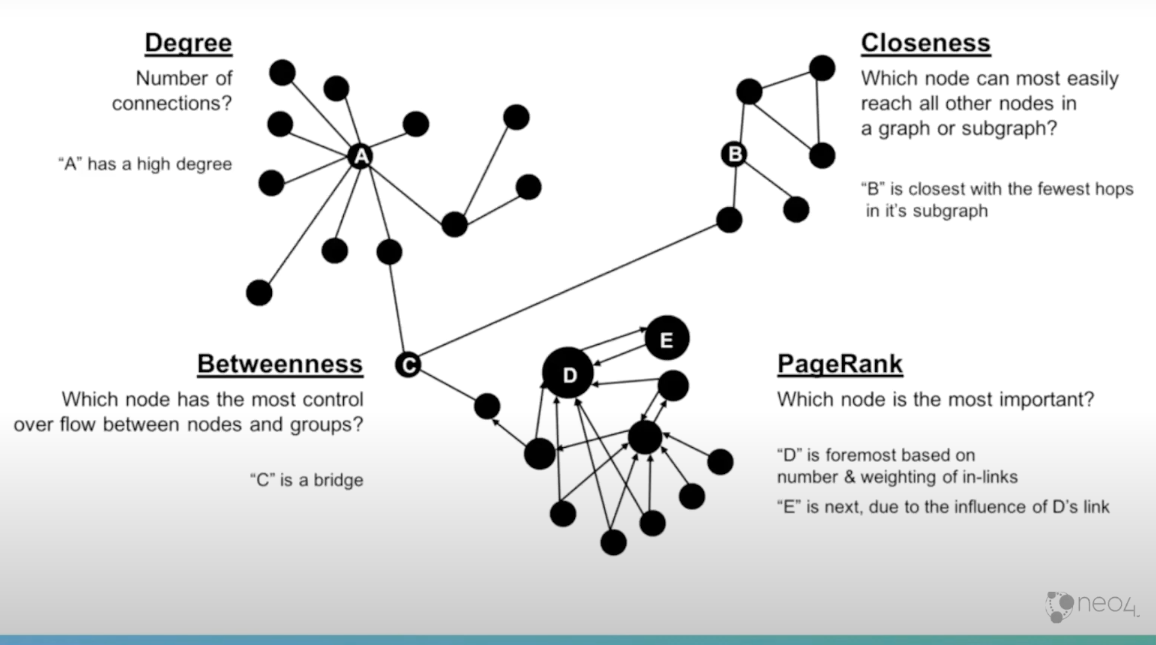

In [53]:
Image(filename = 'centrality.png') 

In [1]:
# Import libraries
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import os
os.chdir('/home/dataguy/Documents/')
import pyspark 
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import udf, col, size, lit, explode, isnan, when, count, min, max, struct, array, monotonically_increasing_id
from neo4j import GraphDatabase, basic_auth
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image

In [2]:
# Class to instantiate a connection instance to neo4j
class establish_conn:
    
    # Init conn with authentication
    def __init__(self, uri, user, pwd):
        
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        
        try:
            
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
            
        except Exception as e:
            
            print("Failed to create the driver:", e)
    
    # Function to sever connection
    def close(self):
        
        if self.__driver is not None:
            
            self.__driver.close()
    
    # Function to query data
    def query(self, query, parameters = None, db = None):
        
        assert self.__driver is not None, "Driver not initialized!"
        
        session = None
        response = None
        
        try: 
            
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        
        except Exception as e:
        
            print("Query failed:", e)
        
        finally: 
        
            if session is not None:
            
                session.close()
        
        return response

In [3]:
# Establish connection
conn = establish_conn(uri = "bolt://52.87.245.216:7687", user = "neo4j", pwd = "relocation-chances-checkpoint")

# Initialize spark
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
spark = SparkSession.builder.getOrCreate()

# Read
df = spark.read.json('/home/dataguy/data/us_news_tweets.json')

22/09/02 21:59:05 WARN Utils: Your hostname, computer resolves to a loopback address: 127.0.1.1; using 192.168.1.159 instead (on interface wlp0s20f3)
22/09/02 21:59:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/09/02 21:59:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/09/02 21:59:06 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/09/02 21:59:06 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/09/02 21:59:06 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/09/02 21:59:15 WARN package: Truncated the string representation of a plan since it was too large. This behav

In [4]:
df.printSchema()

root
 |-- _type: string (nullable = true)
 |-- cashtags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- content: string (nullable = true)
 |-- conversationId: long (nullable = true)
 |-- coordinates: struct (nullable = true)
 |    |-- _type: string (nullable = true)
 |    |-- latitude: double (nullable = true)
 |    |-- longitude: double (nullable = true)
 |-- date: string (nullable = true)
 |-- hashtags: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: long (nullable = true)
 |-- inReplyToTweetId: long (nullable = true)
 |-- inReplyToUser: struct (nullable = true)
 |    |-- _type: string (nullable = true)
 |    |-- created: string (nullable = true)
 |    |-- description: string (nullable = true)
 |    |-- descriptionUrls: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- indices: array (nullable = true)
 |    |    |    |    |-- element: long (containsNull = true)
 |    |    |  

In [5]:
# Expand
df1 = df.withColumn('username', col('user.username')).withColumn('country', col('place.country')).withColumn('country_cd', col('place.countryCode'))
df2 = df1.withColumn('quoted', col('quotedTweet.user.username')).withColumn('mentions', col('mentionedUsers.username')).withColumn('reply_to', col('inReplyToUser.username')).drop('inReplyToUser', 'mentionedUsers', 'renderedContent', 'id', 'media', 'outlinks', '_type', 'cashtags', 'conversationId', 'inReplyToTweetId', 'source', 'sourceUrl', 'sourceLabel', 'tcooutlinks', 'url', 'country', 'lang', 'retweetedTweet', 'coordinates', 'place', 'quotedTweet').sample(.2)
df3 = df2.filter('user.verified == True')

# Extract nodes
users = [x[0] for x in df3.select('username').distinct().collect()]
quoted = [x[0] for x in df3.select('quoted').distinct().collect()]
mentions = df3.select('mentions').distinct().collect()
replies = [x[0] for x in df3.select('reply_to').distinct().collect()]

# Flatten
mnts = []

# Iterate mentions
for x in mentions:
    
    for y in x:
        
            if y:
                
                for z in y:
                
                    mnts.append(z)
                    
nodes = users + quoted + mnts + replies
nodes = pd.DataFrame([i for i in set(nodes)], columns = ['username'])

In [6]:
# Function to for edges
def get_quotes(x, y):

    if y is not None:
        
        edges.append((x, y, 'quote'))
    
    else:
        
        pass
    
def get_mentions(x, y):
    
    if y is not None:
        
        for z in y:
            
            edges.append((x, z, 'mention'))
            
    else:
        
        pass
    
def get_replies(x, y):
    
    if y is not None:
        
        edges.append((x, y, 'reply'))

In [7]:
# Apply functions to build edges
edges = []

# Quotes
for x, y in df3.select('username', 'quoted').collect(): get_quotes(x, y)
for x, y in df3.select('username', 'mentions').collect(): get_mentions(x, y)
for x, y in df3.select('username', 'reply_to').collect(): get_replies(x, y)

# Prepare inputs for datashader
edgedf = pd.DataFrame(edges, columns = ['source', 'target', 'type'])
edgedf = edgedf.groupby(['source', 'target', 'type']).size().reset_index().rename({0: 'weight'}, axis = 1)
edgedf = edgedf[edgedf['source'] != edgedf['target']]

edge_data = pd.DataFrame()

for idx, row in edgedf.iterrows():
    
    x = nodes[nodes['username'] == row['source']].index[0]
    y = nodes[nodes['username'] == row['target']].index[0]
    
    edge_data = edge_data.append({'source': x,
                                  'target': y,
                                  'weight': row['weight']}, ignore_index = True)

In [8]:
edgedf.head()

,source,target,type,weight
0,1059TheRegion,JimLangSports,mention,3
1,1059TheRegion,KarenJohnsonTV,mention,2
2,1623Studios,GDTnews,mention,2
3,1623Studios,PHBPHOTO,mention,2
4,1623Studios,mcricketnews,mention,2


In [17]:
# Init graph
conn.query('create or replace database news')

# Add relationships to graph
types = pd.DataFrame(edgedf['type'].unique(), columns = ['type'])

interactions = '''
                  unwind $rows as row 
                  merge (c: category {type: row.type})  
                  return count(*) as total
              '''
       
res = conn.query(interactions, db = 'news', parameters = {'rows': types.to_dict('records')})
print(f"Successfully processed {res[0]['total']} records..")

Successfully processed 3 records..


In [18]:
# Add users to graph
users = '''
            unwind $rows as row
            merge (n: node {username: row.username})
            return count(*) as total
         '''

nodes = pd.DataFrame(pd.unique(edgedf[['source', 'target']].values.ravel('K')), columns = ['username'])

res = conn.query(users, db = 'news', parameters = {'rows': nodes.to_dict('records')})
print(f"Successfully processed {res[0]['total']} records..")

Successfully processed 3195 records..


In [19]:
# Add tweets to graph
add_edges = '''
              unwind $rows as row
              match (source: node {username: row.source}),
                    (target: node {username: row.target})
              create (source) - [:type {weight: row.weight}] -> (target)
              return count(*) as total
        '''

res = conn.query(add_edges, db = 'news', parameters = {'rows': edgedf.to_dict('records')})    
print(f"Successfully processed {res[0]['total']} records..")

Successfully processed 3116 records..


In [12]:
edgedf.shape[0]

3116

In [20]:
# Build the graph from the news db
build_graph = '''
                 call gds.graph.project('us-news-graph', 'node', 'type')
                 yield graphName, nodeCount, relationshipCount
              '''

res = conn.query(build_graph, db = 'news')

In [26]:
print(f"Success: {res[0]['graphName']}, yielding {res[0]['nodeCount']} vertices and {res[0]['relationshipCount']} edges..")

Success: us-news-graph, yielding 3195 vertices and 3116 edges..


PageRank
---
PageRank measures the transitive (or directional) influence of nodes and is a variant of the Eigenvector Centrality algorithm. Eigenvector Centrality can be used on undirected graphs, whereas the PageRank algorithm is more suited to directed graphs

In [55]:
# Calc centrality
pagerank = '''
              call gds.pageRank.stream('us-news-graph')
              yield nodeId, score
              return gds.util.asNode(nodeId).username as username, score
              order by score desc, username asc 
           '''

res = conn.query(pagerank, db = 'news')    

In [56]:
print('Page Ranking Results for News Network:')
n = 1

for item in res[0:25]:
    
    print(f"{n}.{item['username']}- {round(item['score'], 3)}")
    n += 1

Page Ranking Results for News Network:
1.CornerstoneInc- 0.961
2.EdCast- 0.961
3.NiemanLab- 0.533
4.elonmusk- 0.459
5.WFP- 0.438
6.US_FDA- 0.436
7.AIDS_conference- 0.432
8.Maruti_Corp- 0.405
9.WTOP- 0.405
10.spreaker- 0.405
11.timesofindia- 0.405
12.DGCAIndia- 0.4
13.CUhlmann- 0.386
14.narendramodi- 0.372
15.financialpost- 0.37
16.JetBlue- 0.349
17.CNN- 0.347
18.ABC7NY- 0.341
19.GranadaReports- 0.341
20.KDKA- 0.341
21.WKBW- 0.341
22.WTKR3- 0.341
23.htTweets- 0.341
24.BuzzFeed- 0.332
25.risj_oxford- 0.325


Degree Centrality
---
The Degree Centrality algorithm counts the number of incoming and outgoing relationships from a node. It is used to find popular nodes in a graph

In [57]:
centrality = '''
                call gds.degree.stream('us-news-graph')
                yield nodeId, score
                return gds.util.asNode(nodeId).username as username, score as centrality_measure
                order by centrality_measure desc, username desc
             '''

res = conn.query(centrality, db = 'news')

In [58]:
print('Top 10 Users for Centrality in News Network:')
n = 1

for item in res[0:25]:
    
    print(f"{n}.{item['username']}- {round(item['centrality_measure'], 3)}")
    n += 1

Top 10 Users for Centrality in News Network:
1.ChimpReports- 308.0
2.fpjindia- 290.0
3.IndiaToday- 139.0
4.stratorob- 110.0
5.mid_day- 108.0
6.igtelugu- 47.0
7.Connects_Africa- 37.0
8.lpoolcouncil- 32.0
9.brodfitz- 31.0
10.WCCBCharlotte- 30.0
11.Nyksindia- 30.0
12.dragonwolftech- 26.0
13.NicholasBallasy- 26.0
14.nigelhowardpics- 24.0
15.jr_sonusharma- 22.0
16.officialmudrex- 21.0
17.aashtospeaks- 21.0
18.DailyhuntApp- 21.0
19.77WABCradio- 21.0
20.OttawaCitizen- 20.0
21.LFPress- 20.0
22.Zalman5K- 19.0
23.TheGrowthOp- 19.0
24.PeopleMatters2- 19.0
25.HappyWarriorP- 19.0


Closeness Centrality
---
The Closeness Centrality algorithm is a way of detecting nodes that are able to spread information efficiently through a subgraph. It measures the average farness (inverse distance) from a node to all other nodes. Nodes with a high closeness score have, on average, the shortest distances to all other nodes.

In [63]:
closeness = '''
               call gds.beta.closeness.stream('us-news-graph')
               yield nodeId, score
               return gds.util.asNode(nodeId).username as username, score as closeness_measure
               order by closeness_measure desc, username desc
            '''

res = conn.query(closeness, db = 'news')

In [64]:
print('Top 25 Users for Closeness in News Network:')
n = 1

for item in res[0:25]:
    
    print(f"{n}.{item['username']}- {round(item['closeness_measure'], 3)}")
    n += 1

Top 25 Users for Closeness in News Network:
1.zomato- 1.0
2.zientekglobal- 1.0
3.zehnders- 1.0
4.zavalacourtney- 1.0
5.ysjagan- 1.0
6.yoyen- 1.0
7.ydrcom- 1.0
8.ybruzual- 1.0
9.yadavakhilesh- 1.0
10.xilinjie2017- 1.0
11.xReal_CS- 1.0
12.wusa9- 1.0
13.wto- 1.0
14.wsvn- 1.0
15.wsls- 1.0
16.wsbradio- 1.0
17.woovitinfo- 1.0
18.wmblogistics- 1.0
19.wmata- 1.0
20.wjz- 1.0
21.wisercharlie- 1.0
22.windyday2- 1.0
23.willsmith- 1.0
24.wil_da_beast630- 1.0
25.whatthehillshow- 1.0


Betweenness Centrality
---
Betweenness Centrality is a way of detecting the amount of influence a node has over the flow of information or resources in a graph. It can be used to find nodes that serve as bridges from one part of a graph to another. 

In [70]:
betweeness = '''
               call gds.betweenness.stream('us-news-graph')
               yield nodeId, score
               return gds.util.asNode(nodeId).username as username, score as betweeness_measure
               order by betweeness_measure desc, username desc
            '''

res = conn.query(betweeness, db = 'news')

In [71]:
print('Top 25 Users for Betweenness in News Network:')
n = 1

for item in res[0:25]:
    
    print(f"{n}.{item['username']}- {round(item['betweeness_measure'], 3)}")
    n += 1

Top 25 Users for Betweeness in News Network:
1.TheGrowthOp- 171.5
2.mid_day- 108.0
3.healthing_ca- 81.0
4.nationalpost- 37.5
5.lpoolcouncil- 30.0
6.GSK- 18.0
7.MirrorNow- 12.0
8.Emirates_News- 11.0
9.WFP_Africa- 6.0
10.ttindia- 5.0
11.SGHLpool- 4.0
12.airnewsalerts- 3.0
13.ViiVHC- 3.0
14.GlenGilmore- 3.0
15.ETBrandEquity- 3.0
16.expressupdates- 1.0
17.arabnews- 1.0
18.ZeeBusiness- 1.0
19.US_EDA- 1.0
20.RealFlokiInu- 1.0
21.MontgomeryCoMD- 1.0
22.9NewsMelb- 1.0
23.zurichfilmfest- 0.0
24.zomato- 0.0
25.zientekglobal- 0.0


Eigenvector Centrality
---
The Eigenvector Centrality algorithm measures the transitive (or directional) influence of nodes. Relationships to high-scoring nodes contribute more to the score of a node than connections to low-scoring nodes. A high score means that a node is connected to other nodes that have high scores.

In [72]:
eigenvector = '''
                 call gds.eigenvector.stream('us-news-graph')
                 yield nodeId, score
                 return gds.util.asNode(nodeId).username as username, score as eigenvector_measure
                 order by eigenvector_measure desc, username desc
              '''

res = conn.query(eigenvector, db = 'news')

In [73]:
print('Top 25 Users for Eigenvector in News Network:')
n = 1

for item in res[0:25]:
    
    print(f"{n}.{item['username']}- {round(item['eigenvector_measure'], 3)}")
    n += 1

Top 25 Users for Eigenvector in News Network:
1.CultureLPool- 0.309
2.stratusimagery- 0.154
3.srcdoyle- 0.154
4.lpoolcouncil- 0.154
5.fraz_lake- 0.154
6.cunardline- 0.154
7.cllrkemp- 0.154
8.bbcproms- 0.154
9.balticcreative- 0.154
10.ZutMediaTV- 0.154
11.VisitLiverpool- 0.154
12.SGHLpool- 0.154
13.RedBallProject- 0.154
14.PeelLivWaters- 0.154
15.MetroMayorSteve- 0.154
16.MerseysidePCC- 0.154
17.Mersey_Maritime- 0.154
18.MerseyPolice- 0.154
19.MayorLpool- 0.154
20.LpoolMarketing- 0.154
21.LpoolCityRegion- 0.154
22.LpoolChamber- 0.154
23.LpoolBIDcompany- 0.154
24.LiverpoolPH- 0.154
25.LiverpoolCVS- 0.154
